# Ergodicity Insurance - Tail Simulation - Parallel

In [1]:
!pip install --user --upgrade --force-reinstall git+https://github.com/AlexFiliakov/Ergodic-Insurance-Limits

  Cloning https://github.com/AlexFiliakov/Ergodic-Insurance-Limits to /tmp/pip-req-build-aourks7r
  Running command git clone --filter=blob:none --quiet https://github.com/AlexFiliakov/Ergodic-Insurance-Limits /tmp/pip-req-build-aourks7r
  Resolved https://github.com/AlexFiliakov/Ergodic-Insurance-Limits to commit 79b04b279455e4952047b4935f23fb6ebc2ca9a7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pydantic-2.12.0-py3-none-any.whl.metadata (83 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB

In [2]:
import sys
import os
import glob

# Add user site-packages to the system path
user_site_packages = os.path.expanduser("~/.local/lib/python*/site-packages")
sys.path.extend(glob.glob(user_site_packages)) # Use glob to handle potential version differences

import ergodic_insurance as ei

ei.__version__

'0.3.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys # Import sys
import glob # Import glob

# Define the directory containing the module from Google Drive
module_dir = "/content/drive/MyDrive/Colab Notebooks"

# Add the directory to sys.path if it's not already there
if module_dir not in sys.path:
    sys.path.append(module_dir)
    print(f"Added {module_dir} to sys.path within cell WfwYS382ns8Y")

# Now import the module from the file in Google Drive
try:
    from run_hier_tail_sim_colab import run_hier_tail_simulation
    print("Successfully imported run_hier_tail_simulation from run_hier_tail_sim_colab.py within cell WfwYS382ns8Y")
except ModuleNotFoundError:
    print("Could not import run_hier_tail_simulation from run_hier_tail_sim_colab.py within cell WfwYS382ns8Y.")
    print("Please ensure that run_hier_tail_sim_colab.py exists directly in the /content/drive directory and contains the 'run_hier_tail_simulation' function.")
    # Re-raise the error so the user sees it
    raise
except ImportError as e:
    print(f"An error occurred during import within cell WfwYS382ns8Y: {e}")
    # Re-raise the error so the user sees it
    raise

Added /content/drive/MyDrive/Colab Notebooks to sys.path within cell WfwYS382ns8Y
Successfully imported run_basic_simulation from run_tail_simulation_colab.py within cell WfwYS382ns8Y


In [5]:
# import os
# import glob

# # Get the current working directory
# current_directory = os.getcwd()
# print(f"Current working directory: {current_directory}")

# # List all .pkl files in the current directory
# pkl_files = glob.glob(os.path.join(current_directory, '*.pkl'))

# # Delete each file
# if pkl_files:
#     for file_path in pkl_files:
#         os.remove(file_path)
#         print(f"Deleted: {file_path}")
#     print("All .pkl files in the current working directory have been deleted.")
# else:
#     print("No .pkl files found in the current working directory.")

In [ ]:
from tqdm.notebook import tqdm  # progress bar
from itertools import product
import os
from joblib import Parallel, delayed
import shutil  # Import shutil for file operations
import numpy as np
from scipy import stats
from scipy.stats import beta, gamma
from scipy.stats.qmc import Sobol
import pickle


def generate_2d_sobol_parameters(m=10, seed=42):
    """
    Generate 2D Sobol sequence for frequency multiplier and GPD shape parameter.

    Parameters
    ----------
    m : int, optional
        Exponent for number of Sobol points (generates 2^m points). Default is 10 (1024 points).
    seed : int, optional
        Random seed for Sobol sequence scrambling. Default is 42.

    Returns
    -------
    parameters : np.ndarray
        Array of shape (2^m, 2) where:
        - Column 0: frequency_multiplier (Gamma(10, 0.1) distribution, mean=1.0)
        - Column 1: excess_shape (unbounded, from Beta(2,3) scaled to [0.5, 0.8] then logit transformed, bounded above by 1.5)

    Examples
    --------
    >>> params = generate_2d_sobol_parameters(m=10, seed=42)
    >>> params.shape
    (1024, 2)
    >>> print(f"Frequency multiplier mean: {params[:, 0].mean():.3f}")
    >>> print(f"Shape parameter range: [{params[:, 1].min():.3f}, {params[:, 1].max():.3f}]")
    """

    # Initialize 2D Sobol sequence
    sampler = Sobol(d=2, scramble=True, seed=seed)
    n_points = 2 ** m

    # Generate uniform Sobol draws
    uniform_samples = sampler.random_base2(m=m)

    # Transform dimension 0: Frequency multiplier ~ Gamma(shape=10, scale=0.1)
    frequency_multiplier = gamma.ppf(uniform_samples[:, 0], a=10, scale=0.1)

    # Transform dimension 1: Excess Shape parameter
    # Step 1: Transform uniform to Beta(2,3)
    beta_samples = beta.ppf(uniform_samples[:, 1], a=2, b=3)

    # Step 2: Scale to [0.5, 0.8]
    bounded_shape = 0.5 + 0.3 * beta_samples

    # Step 3: Apply logit transformation to make unbounded
    # logit with upper bound = 0.8: log10(x / (0.8 - x))
    excess_shape_unbounded = np.log10(bounded_shape / (0.8 - bounded_shape))

    # Step 4: Bound above by 1.5
    excess_shape_unbounded = np.minimum(excess_shape_unbounded, 1.5)

    # Combine into output array
    parameters = np.column_stack(
        [frequency_multiplier, excess_shape_unbounded])

    return parameters


# Cache Sobol parameters to avoid regenerating
cache_file = "freq_mult_extreme_sev_params.pkl"

if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
        freq_mult_extreme_sev_params = pickle.load(f)
    print(f"Loaded cached parameters from {cache_file}")
else:
    freq_mult_extreme_sev_params = generate_2d_sobol_parameters(m=10, seed=42)
    with open(cache_file, 'wb') as f:
        pickle.dump(freq_mult_extreme_sev_params, f)
    print(f"Generated and cached parameters to {cache_file}")

print(f"Generated {freq_mult_extreme_sev_params.shape[0]} parameter pairs")
print(f"Frequency multiplier: mean={freq_mult_extreme_sev_params[:, 0].mean():.3f}, std={freq_mult_extreme_sev_params[:, 0].std():.3f}")
print(f"Excess shape (unbounded): min={freq_mult_extreme_sev_params[:, 1].min():.3f}, max={freq_mult_extreme_sev_params[:, 1].max():.3f}")
# print(freq_mult_extreme_sev_params)

NUM_SIMULATIONS = 10_000
SIM_YEARS = 25
PRICING_SIMULATIONS = 500_000  # For premium estimation

# Test assumptions
NUM_SIMULATIONS = 1_000
PRICING_SIMULATIONS = 5_000

initial_assets_list = [75_000_000]
atr_list = [1.0]
ebitabl_list = [0.1]
deductible_list = [100_000, 250_000, 500_000, 1_000_000]
loss_ratio_list = [0.6]
policy_limit_list = [75_000_000, 150_000_000, 250_000_000, 350_000_000, 500_000_000, 1_000_000_000]
extreme_threshold_percentile = [0.0005]
# extreme_sev_shape = [2.5]
# Scale at the 1/10th of the threshold percentile of catastrophic severity
extreme_sev_scale_percentile = [1.0]
# extreme_sev_shape = []  # Sobol
# freq_scale = []  # Sobol

prod_with_extreme_thresholds = product(
                                    initial_assets_list,
                                    atr_list,
                                    ebitabl_list,
                                    deductible_list,
                                    loss_ratio_list,
                                    policy_limit_list,
                                    freq_mult_extreme_sev_params,
                                    extreme_threshold_percentile,
                                    # extreme_sev_shape,
                                    extreme_sev_scale_percentile
                                )

len(list(prod_with_extreme_thresholds))

# for index, (ia, atr, ebitabl, ded, lr, policy_limit, (freq_scale, extreme_sev_scale), extreme_threshold, extreme_sev_shape) in enumerate(prod_with_extreme_thresholds_list):
#     print(prod_with_extreme_thresholds_list[index])
    # print(index, freq_scale, extreme_sev_scale)

Generated and cached parameters to freq_mult_extreme_sev_params.pkl
Generated 1024 parameter pairs
Frequency multiplier: mean=1.000, std=0.316
Excess shape (unbounded): min=0.229, max=1.500


24576

In [ ]:
from tqdm.notebook import tqdm  # progress bar
from itertools import product
import os
from joblib import Parallel, delayed
import shutil # Import shutil for file operations

from run_hier_tail_sim_colab import run_hier_tail_simulation

# Integrate joblib with tqdm for per-task progress
class TqdmJoblib(tqdm):
    def __enter__(self):
        from joblib import parallel
        self._original = parallel.BatchCompletionCallBack
        outer = self
        class TqdmBatchCompletionCallback(parallel.BatchCompletionCallBack):
            def __call__(self, *args, **kwargs):
                outer.update(n=self.batch_size)
                return super().__call__(*args, **kwargs)
        parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        return super().__enter__()
    def __exit__(self, exc_type, exc, tb):
        from joblib import parallel
        parallel.BatchCompletionCallBack = self._original
        return super().__exit__(exc_type, exc, tb)

# # Test overrides
# loss_ratio_list = [0.7]
# policy_limit_list = [50_000_000]
# extreme_threshold_percentile = [0.0005]
# extreme_sev_shape = [1.5]
# extreme_sev_scale_percentile = [1.5]  # Scale at the 1/10th of the threshold percentile of catastrophic severity

# Use all but one CPU core
_cpu = os.cpu_count() or 1
n_jobs = max(_cpu, 1)

print(f'Available cores: {n_jobs}')

# Define the destination directory in your Google Drive
# Make sure 'My Drive/results' exists in your Google Drive
gdrive_results_dir = '/content/drive/My Drive/Colab Notebooks/results'
os.makedirs(gdrive_results_dir, exist_ok=True) # Create the directory if it doesn't exist

# prod_without_extreme_thresholds = product(
#                                     initial_assets_list,
#                                     atr_list,
#                                     ebitabl_list,
#                                     deductible_list,
#                                     loss_ratio_list,
#                                     policy_limit_list,
#                                     [None],
#                                     [0.0],
#                                     [1.0]
#                                 )

prod_combined = list(prod_with_extreme_thresholds) # + list(prod_without_extreme_thresholds)

total_combos = len(prod_combined)

# Parallel execution with progress bar
with TqdmJoblib(total=total_combos, desc="Parameter sets", leave=True):
    Parallel(n_jobs=n_jobs, prefer="processes", batch_size=1)(
        delayed(run_hier_tail_simulation)(
            index, ia, atr, ebitabl, ded, lr, policy_limit, freq_scale,
            extreme_threshold, extreme_sev_shape, extreme_sev_scale,
            NUM_SIMULATIONS, SIM_YEARS, PRICING_SIMULATIONS,
            filepath=gdrive_results_dir
        )
        index, (ia, atr, ebitabl, ded, lr, policy_limit, (freq_scale, extreme_sev_scale), extreme_threshold, extreme_sev_shape) in enumerate(prod_combined)
    )

Available cores: 44


Parameter sets:   0%|          | 0/208 [00:00<?, ?it/s]

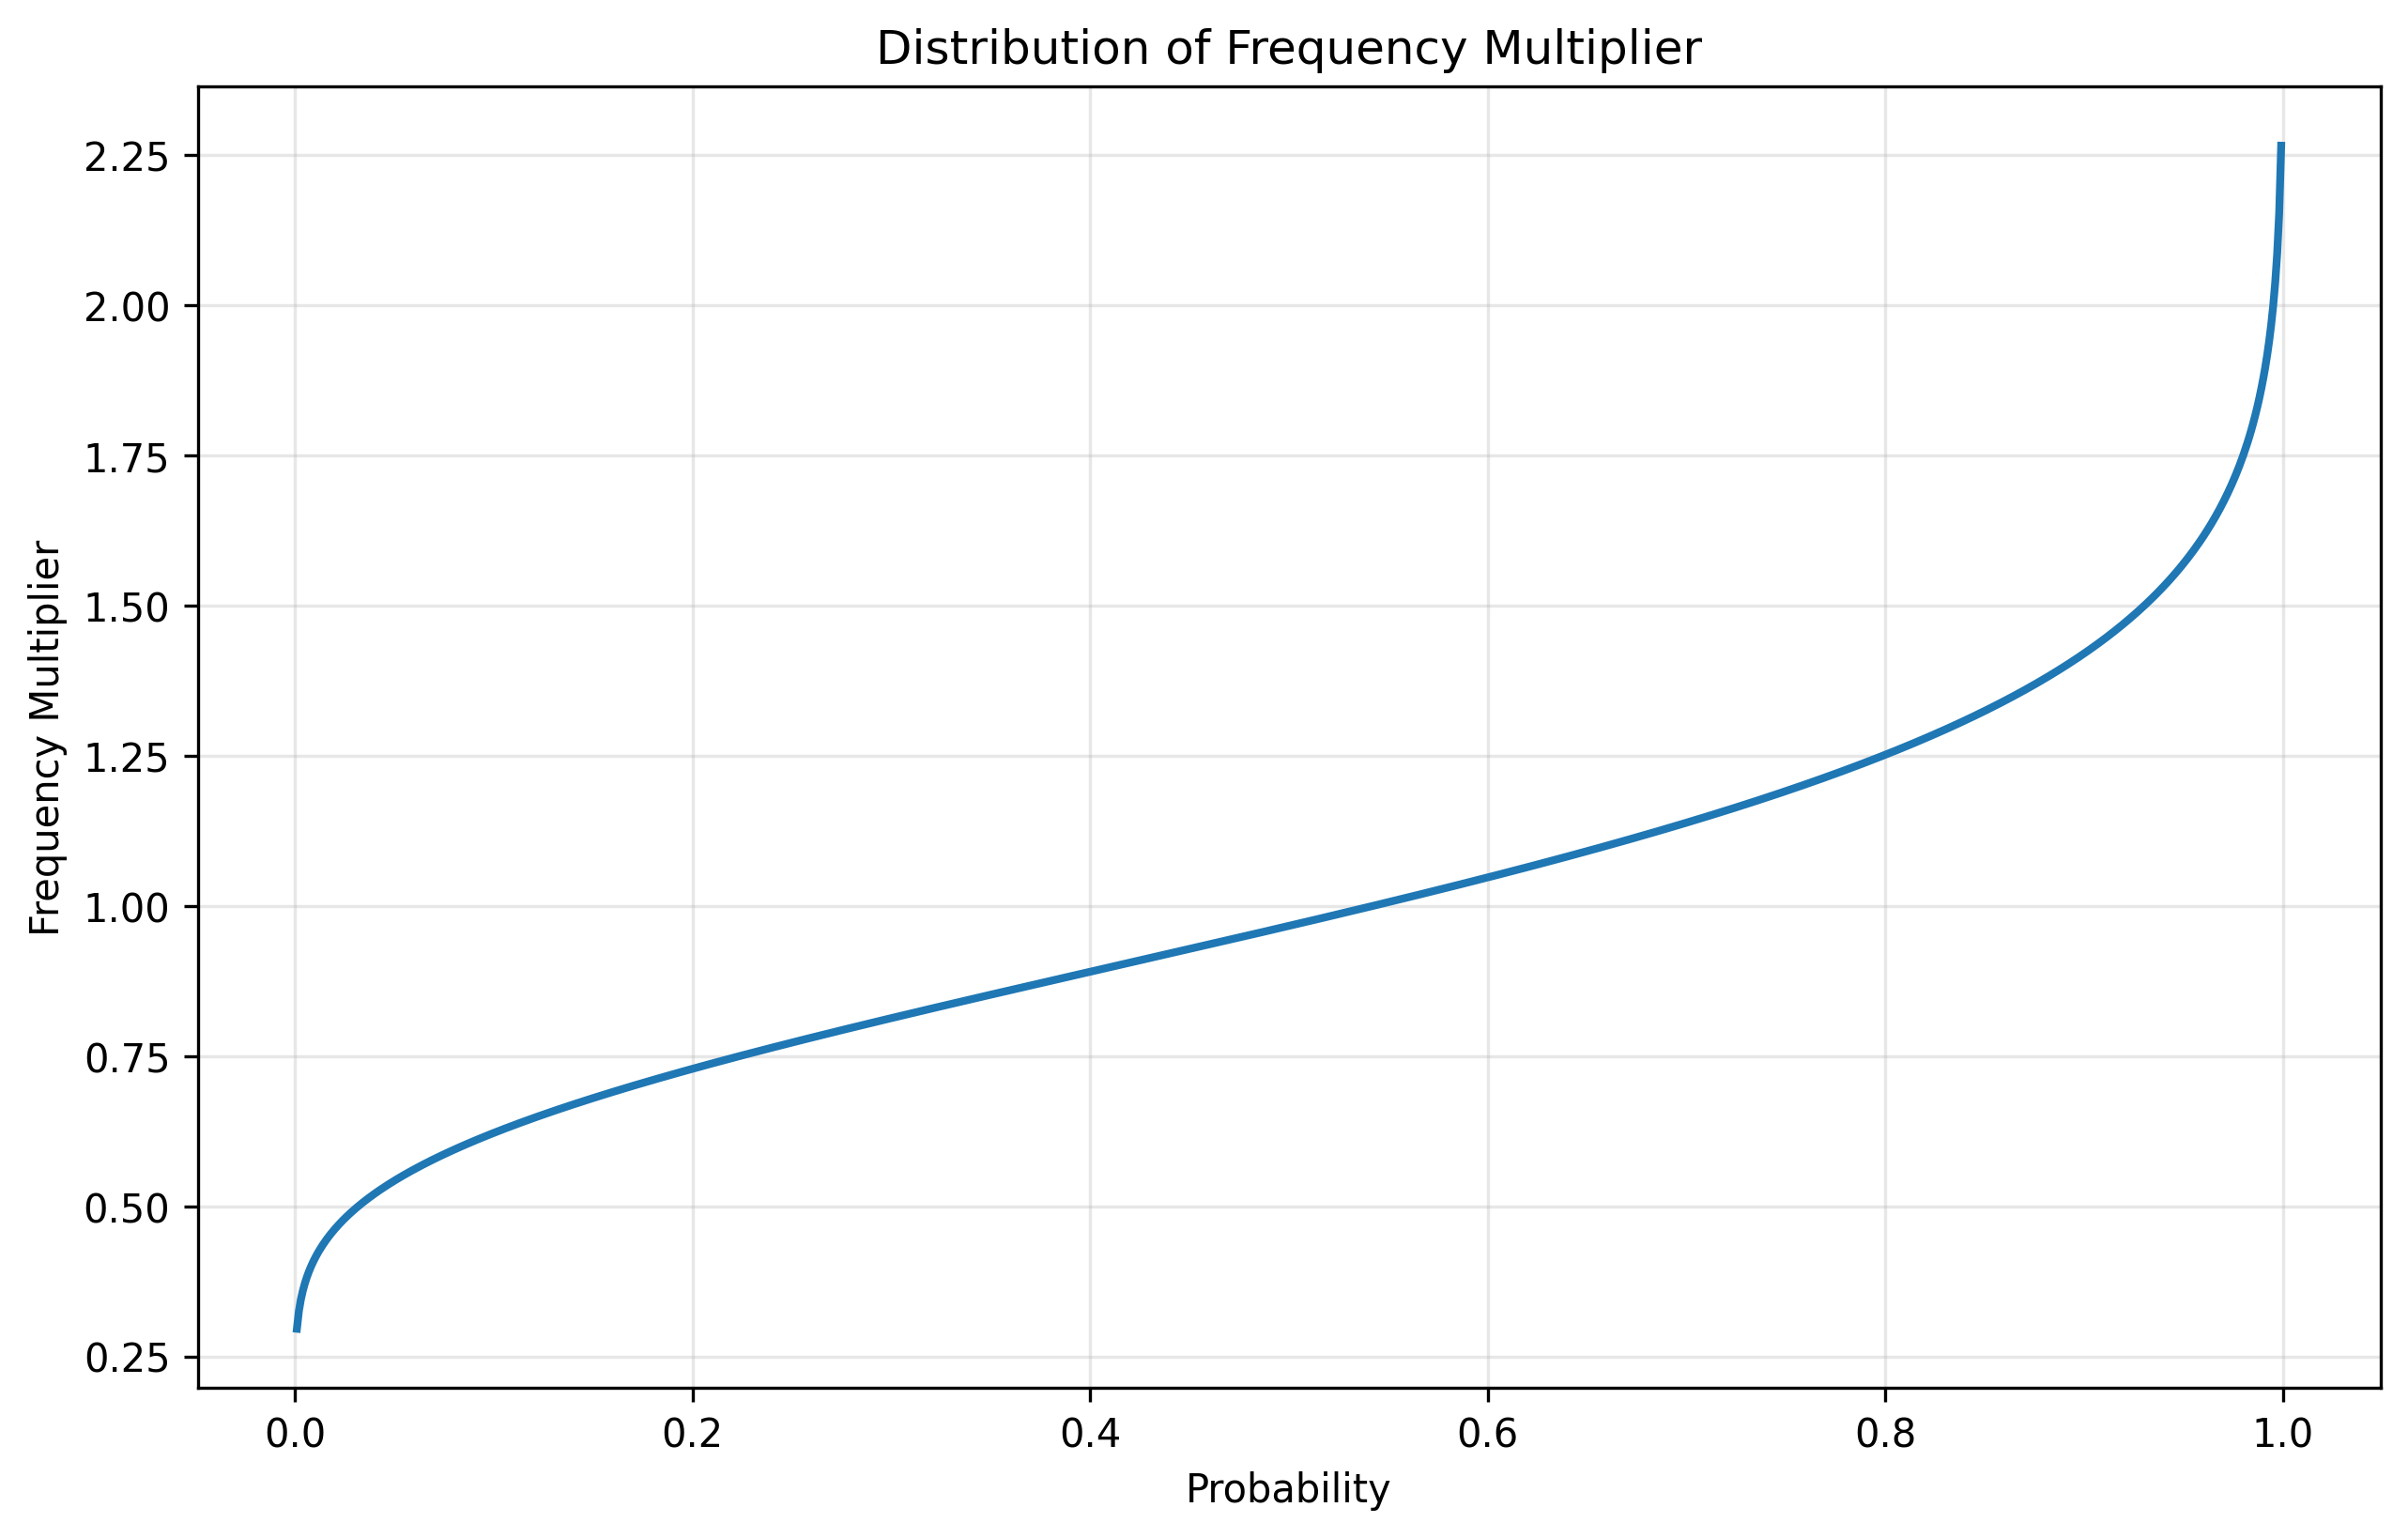

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gamma

# Base case: Beta prior scaled to manufacturing-appropriate range
def freq_multiplier():
    """Gamma with shape 10 and scale 0.1"""
    return lambda x: gamma.ppf(x, a=10, scale=0.1)

x = freq_multiplier()([0.001, 0.2, 0.995])

# Generate samples across the full probability range
prob_range = np.linspace(0.001, 0.999, 1000)
shape_values = freq_multiplier()(prob_range)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(prob_range, shape_values, linewidth=2)
plt.xlabel('Probability')
plt.ylabel('Frequency Multiplier')
plt.title('Distribution of Frequency Multiplier')
plt.grid(True, alpha=0.3)
plt.gcf().set_dpi(300)
plt.show()

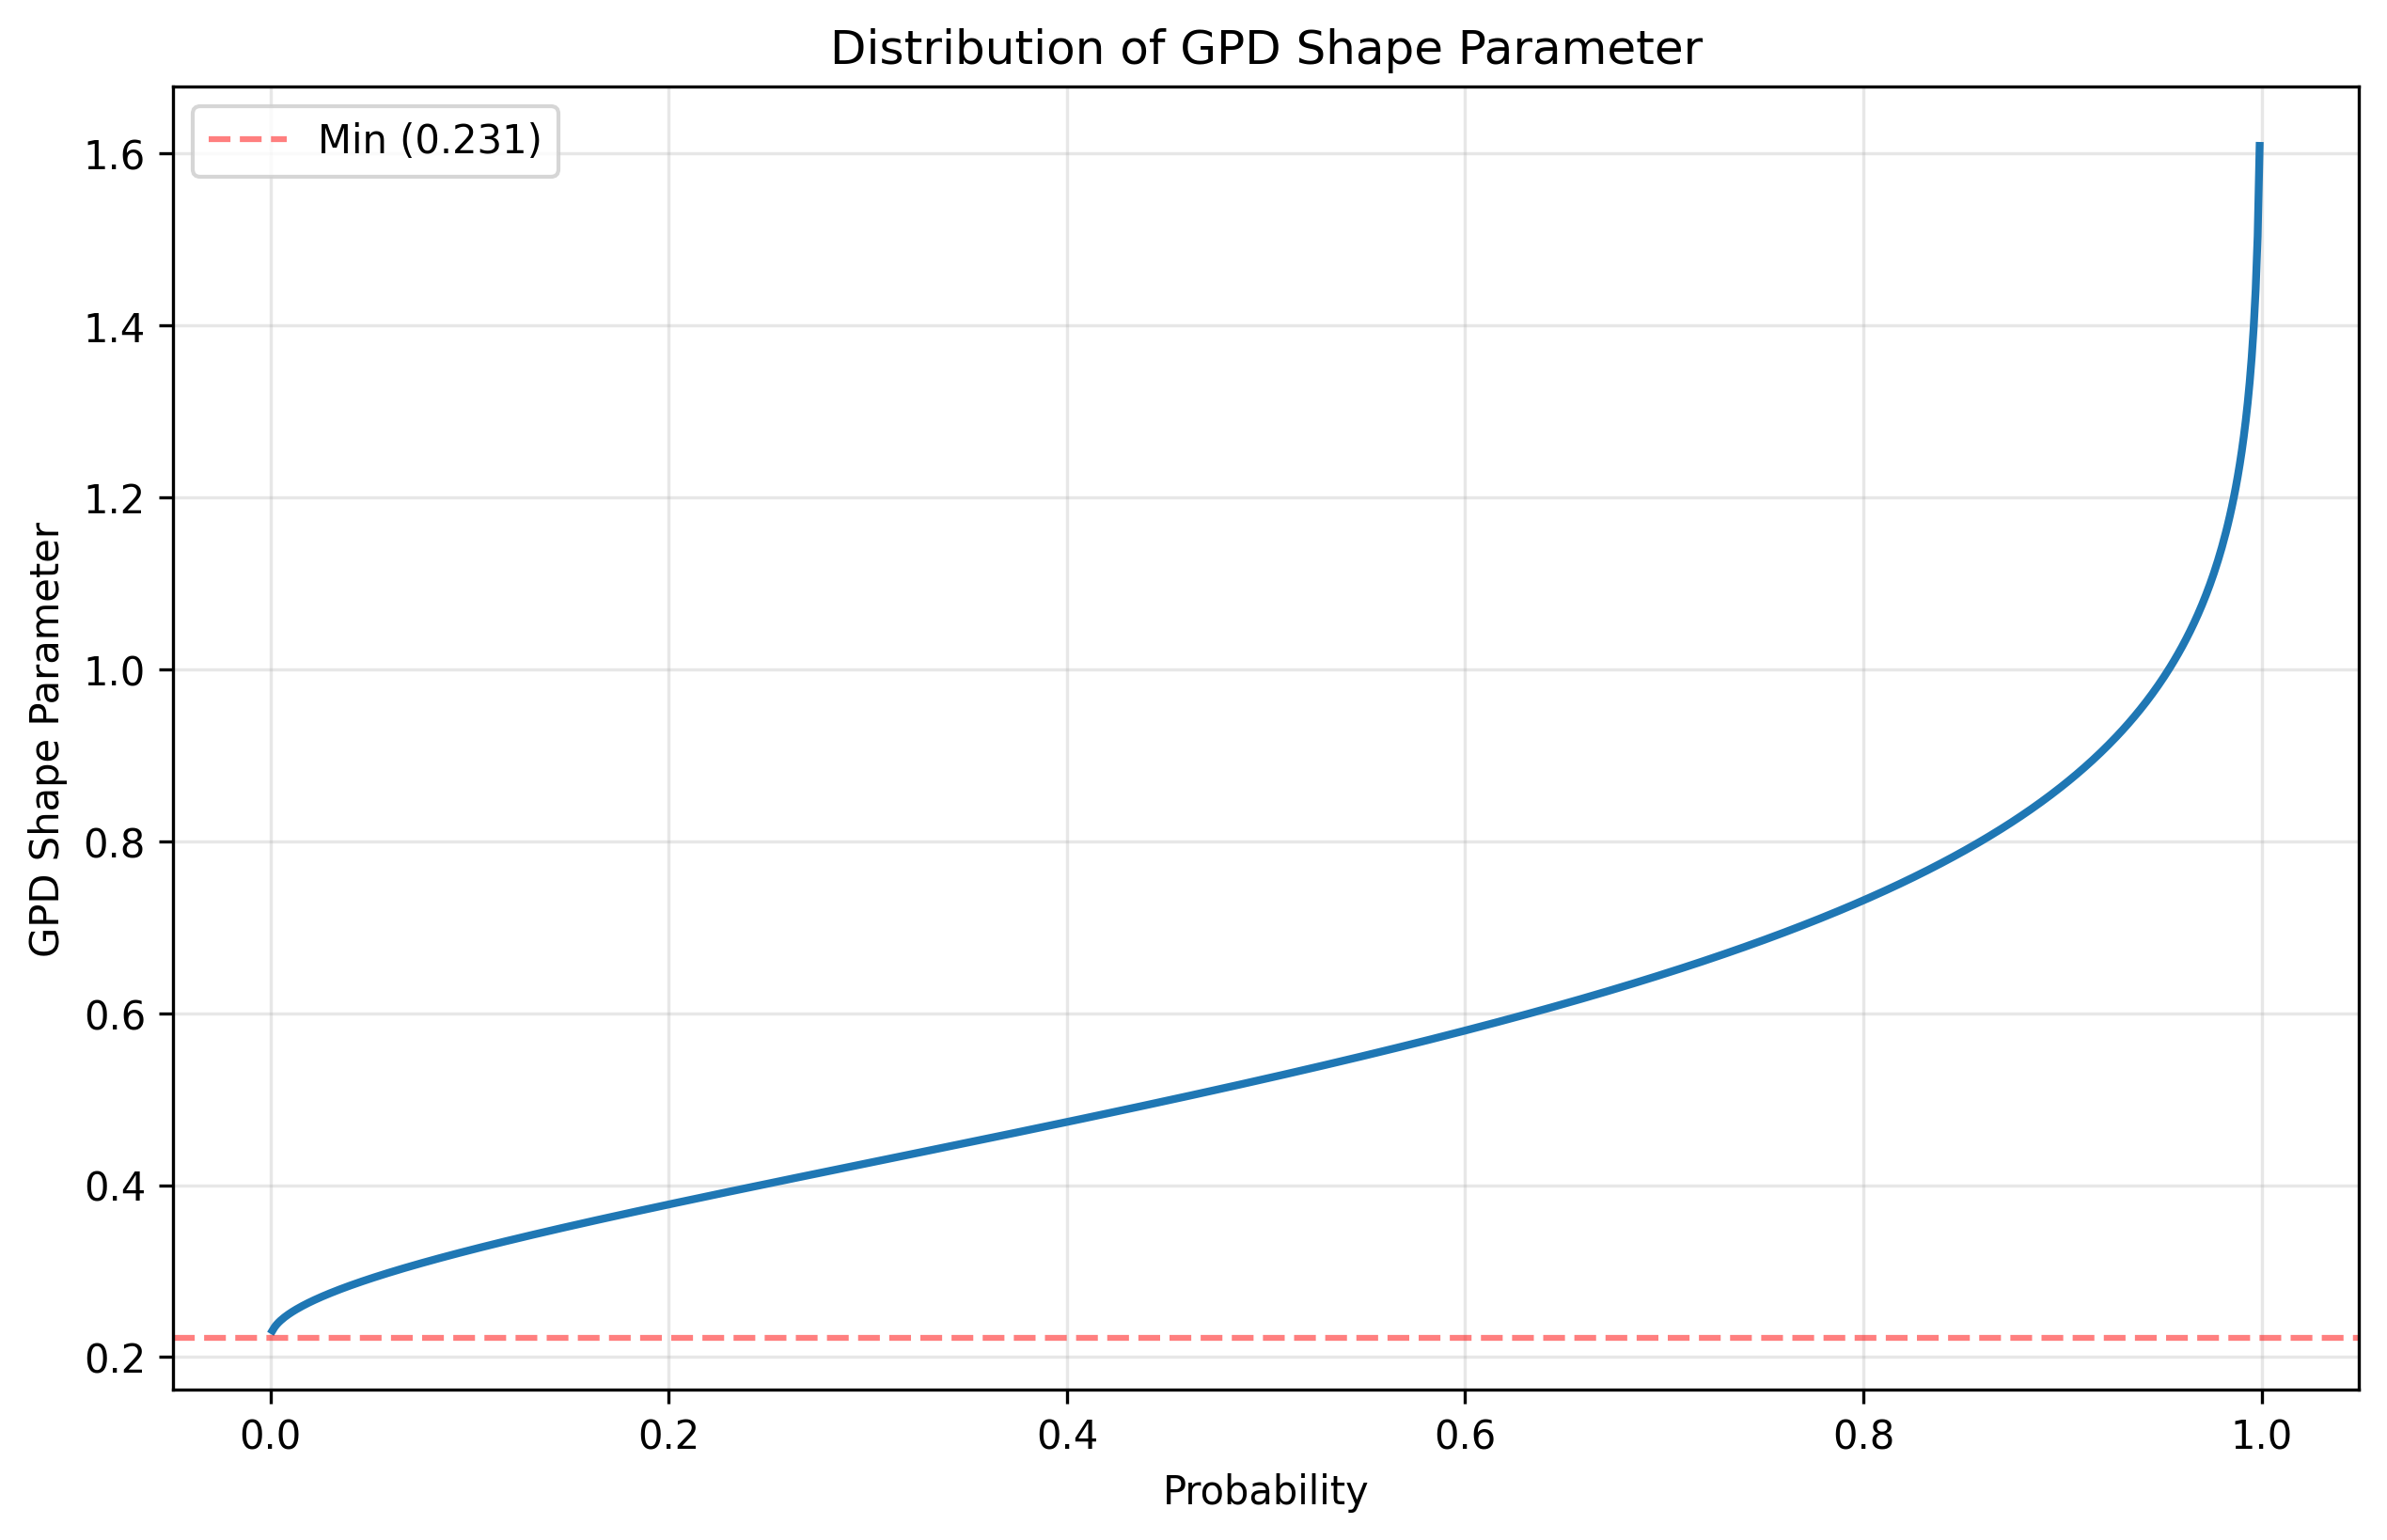

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import beta

# Base case: Beta prior scaled to manufacturing-appropriate range
def gpd_shape_prior_base_unbounded():
    """Beta(2,3) prior scaled to [0.5, 0.8] then made unbounded via logit."""
    bounded_x = lambda x: 0.5 + 0.3 * beta.ppf(x, a=2, b=3)
    return lambda x: np.log10(bounded_x(x) / (0.8 - bounded_x(x)))

x = gpd_shape_prior_base_unbounded()([0.001, 0.2, 0.995])

# Generate samples across the full probability range
prob_range = np.linspace(0.001, 0.999, 1000)
shape_values = gpd_shape_prior_base_unbounded()(prob_range)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.plot(prob_range, shape_values, linewidth=2)
plt.xlabel('Probability')
plt.ylabel('GPD Shape Parameter')
plt.title('Distribution of GPD Shape Parameter')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.log10(0.5 / (0.8 - 0.5)), color='r', linestyle='--', alpha=0.5, label=f'Min ({np.min(x):0.3f})')
# plt.axhline(y=np.log10(0.8 / (0.8 - 0.8)), color='r', linestyle='--', alpha=0.5, label='Max (0.8)')
plt.legend()
plt.gcf().set_dpi(300)
plt.show()

C:\Users\alexf\AppData\Local\Temp\ipykernel_11184\3136358633.py:64: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  severity_uniforms = severity_sampler.random(n=n_losses)


Risk Metrics for $10M xs $10M Layer:
Expected Loss: $19.72M
99.5% VaR: $48.19M
95% TVaR: $41.85M
Prob of Limit Exhaustion: 85.82%


C:\Users\alexf\AppData\Local\Temp\ipykernel_11184\3136358633.py:148: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  severity_uniforms = severity_sampler.random(n=n_losses)



Sensitivity to Shape Parameter Prior:

Base Prior:
  Mean Loss: $19.62M
  99.5% VaR: $48.42M

Conservative Prior:
  Mean Loss: $21.02M
  99.5% VaR: $52.38M

Optimistic Prior:
  Mean Loss: $17.55M
  99.5% VaR: $42.73M
